This code is used to split the data

In [2]:
import json
import numpy as np
import os

scene_list_file = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
scene_root = '/ssddata/yliugu/data'
with open(scene_list_file) as f:
    scene_dict = json.load(f)
scene_list = []
for k in list(scene_dict.keys()):
    scene_list.extend(scene_dict[k])
for s in scene_list:
    cur_scene_root = os.path.join(scene_root, s) 
    cur_img_root = os.path.join(cur_scene_root, 'images')
    all_img_list = os.listdir(cur_img_root)
    all_img_list.sort()
    
    skip = 3
    if len(all_img_list) > 200:
        skip = 2
    val_list = all_img_list[::skip]
    train_list = [i for i in all_img_list if i not in val_list]
    if len(train_list) < 50:
        val_list = all_img_list
        train_list = all_img_list
    data_split = {
        'train': train_list,
        'test': val_list
    }
    with open(os.path.join(cur_scene_root, 'data_split.json'), '+w') as f:
        json.dump(data_split, f, indent=4)
        
    

This code is used to splite data into eval and train.

In [ ]:
import os.path as path
import os
import glob
scene_path = '/ssddata/yliugu/Segment-Anything-NeRF/scene_list.json'
metadata_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata.json'
workspace_root = '/ssddata/yliugu/trial_model_final/sam_nerf'
data_root = '/ssddata/yliugu/data'
scene_root = '/ssddata/yliugu/data'
scene_list = []
with open(metadata_path) as f:
    meta = json.load(f)

scene_list = list(meta.keys())
scene_list = ["bonsai"]
for scene_name in scene_list:
    split_path = path.join(data_root, scene_name, 'data_split.json')
    for object_name in list(meta[scene_name].keys()):
        

This code is used to select evaluation views automatically.

In [303]:
import json
import os
import os.path as path
import random
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(meta_path) as f:
    meta = json.load(f)

data_root = '/ssddata/yliugu/data'
name = '3dfront_0019_00'
eval_num = 8
with open(path.join(data_root, name, 'eval_pose.json')) as f:
    eval_json = json.load(f)
image_names = os.listdir(path.join(data_root, name, 'images_4'))
print(len(image_names))
# for i in image_names:
#     if i[:4] != "DSCF":
#         image_names.remove(i)
        
        
        
key_list = list(eval_json.keys())
for i in key_list:
    auto = eval_json[i]['auto'] if 'auto' in key_list else [] 
    # load valid indices
    with open(path.join(data_root, name, f'train_{i}_nerf', 'valid.json')) as f:
        valid_indices = json.load(f)

    # print(list(valid_indices.keys()))
    # print(image_names[0][:-4])
    key_img_names = [n for n in image_names if n[:-4] in list(valid_indices.keys()) and valid_indices[n[:-4]] == 1]        
        
    for j in range(eval_num - len(eval_json[i]['select'])- len(auto)):
        s = None
        while s in eval_json[i]['select'] or s in auto or s is  None:
            s = random.choice(key_img_names)[:-4]
        auto.append(s)
    eval_json[i]['auto'] = auto

with open(path.join(data_root, name, 'eval_pose.json'), 'w+') as f:
    json.dump(eval_json, f, indent = 4)

42


The code is used to create evalutation sets 

In [73]:
import json
import os
import os.path as path
import random
import glob
import cv2
meta_path = '/ssddata/yliugu/Segment-Anything-NeRF/scenes_metadata_v2.json'
with open(meta_path) as f:
    meta = json.load(f)

data_root = '/ssddata/yliugu/data'
name = 'waldo_kitchen'

with open(path.join(data_root, name, 'eval_pose.json')) as f:
    eval_json = json.load(f)


sam_root = path.join('/ssddata/yliugu/trial_model_final/sam_nerf', name)
ckpt_path = path.join(sam_root, 'checkpoints')
checkpoint_list = sorted(glob.glob(f'{ckpt_path}/*.pth'))
latest = path.basename(checkpoint_list[-1])
epoch = latest[-8:-4]


for i in list(eval_json.keys()):
    target_root = path.join(data_root, name, f'eval_{i}')
    os.makedirs(target_root,  exist_ok=True)
    image_names = eval_json[i]['auto']
    image_names.extend(eval_json[i]['select'])
    for img_name in image_names:
        target_path = path.join(target_root, f'ori_{img_name}.png')
        img_path = path.join(sam_root, 'validation', f'ngp_ep{epoch}_{img_name}_rgb.png')
        img = cv2.imread(img_path)
        cv2.imwrite(target_path, img)
        
        
        
        

The code is for get the gt

In [6]:
from segment_anything import SamPredictor, sam_model_registry_baseline
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
import os

# os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import os.path as path
import json
import time
import segmentation_refinement as refine
refiner = refine.Refiner(device='cuda:3') # device can also be 'cpu'

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    
sam = sam_model_registry_baseline["vit_h"](checkpoint="/ssddata/yliugu/Segment-Anything-NeRF/pretrained/sam_vit_h_4b8939.pth").to('cuda:3')
predictor = SamPredictor(sam)



/home/yliugu/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


frame_00022


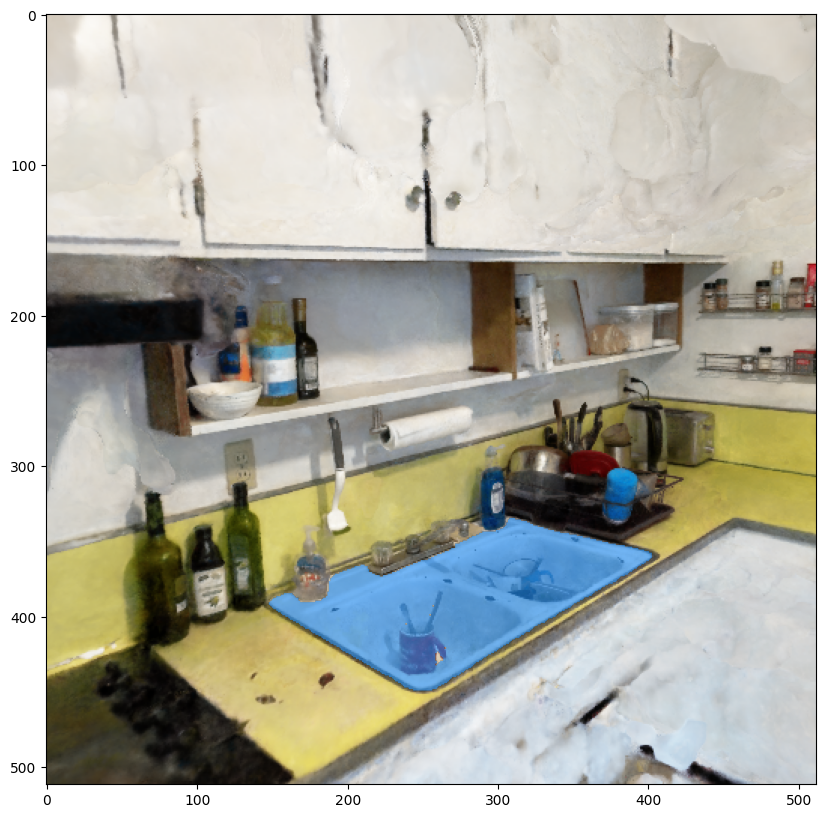

In [82]:
import cv2
data_root = '/ssddata/yliugu/data'
name = 'waldo_kitchen'
key = 'sink'

img_index = 9


with open(path.join(data_root, name, 'eval_pose.json')) as f:
    eval_json = json.load(f)

target_root = path.join(data_root, name, f'eval_{key}')

image_names = eval_json[key]['auto']
image_names.extend(eval_json[key]['select'])
    
print(image_names[img_index])
image = cv2.imread(path.join(target_root, 'ori_'+image_names[img_index]+'.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

input_mask = np.load(path.join(data_root, name, f'train_{key}_sam', image_names[img_index]+'_masks.npy'))

# plt.figure(figsize=(10,10))
# plt.imshow(image)
# show_mask(input_mask[...,0], plt.gca())
# # show_box(input_box, plt.gca())
# plt.axis('on')
# plt.show() 
# plt.close() 


input_mask = (input_mask * 255).astype(np.int64)
new_input = np.zeros([ 512,512, 3])
new_input[..., 0] =input_mask[..., 0]
new_input[..., 1] =input_mask[..., 0]
new_input[..., 2] =input_mask[..., 0]
new_input = new_input.astype('uint8')


mask_0 = cv2.imread(path.join(target_root, 'mask_'+image_names[img_index]+'.png'))
new_input = (new_input > 128) + (mask_0 > 128)
new_input = (new_input>0)*255
cv2.imwrite(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), new_input)


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(new_input[...,0] > 0, plt.gca())
# show_box(input_box, plt.gca())
plt.axis('on')
plt.show() 
plt.close() 
new_input = new_input.astype('uint8')

new_input = cv2.resize(new_input, dsize=(256,256))
new_input = new_input[..., 0] / 255 * 10


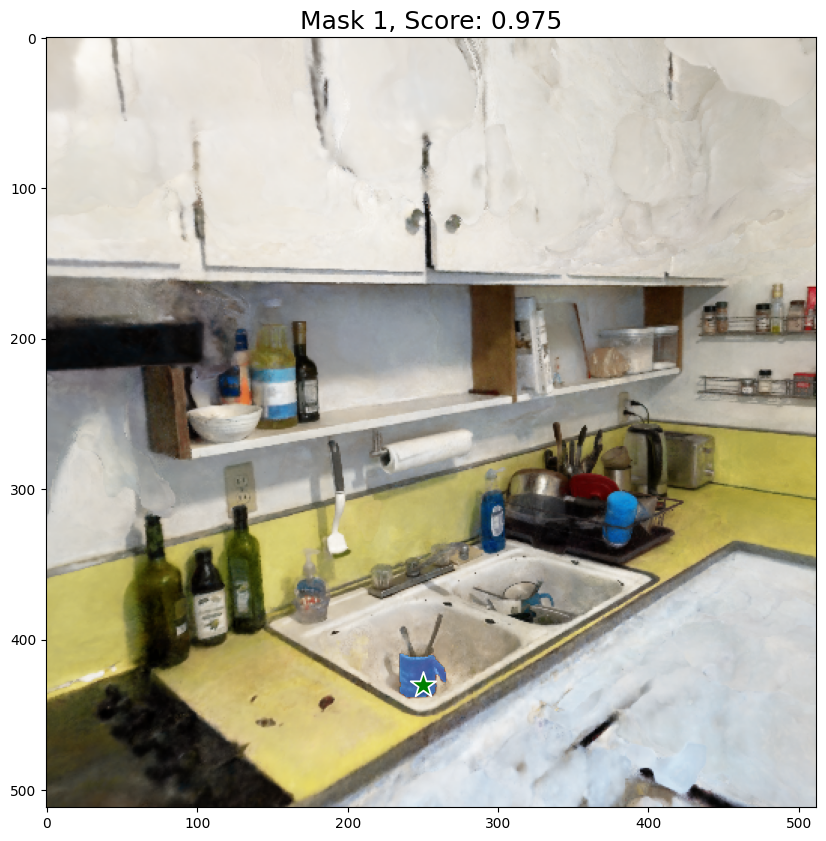

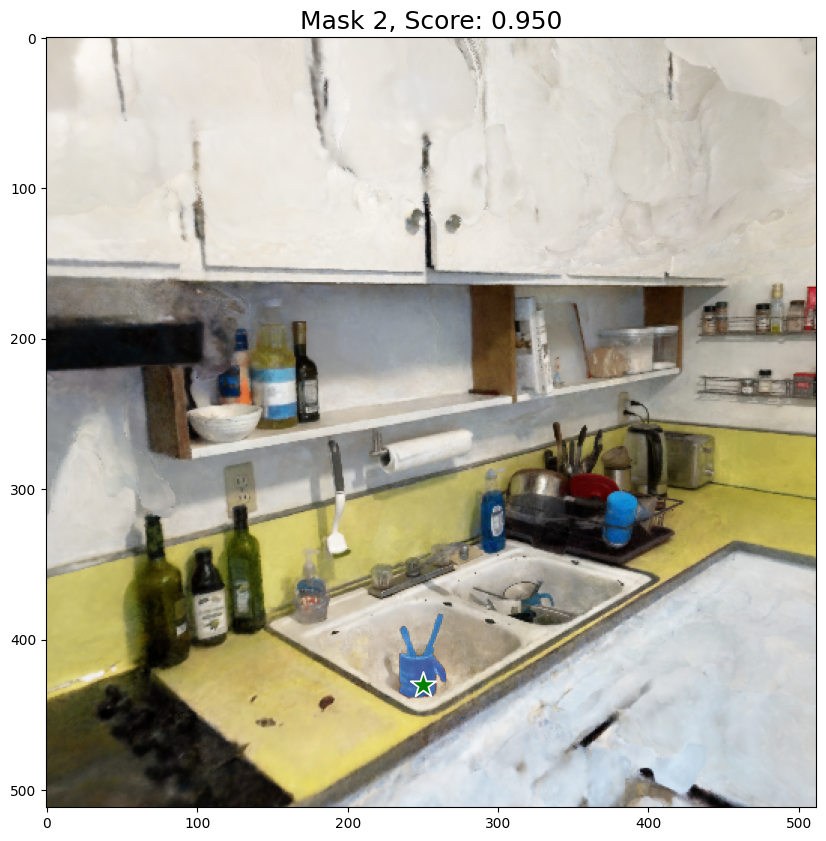

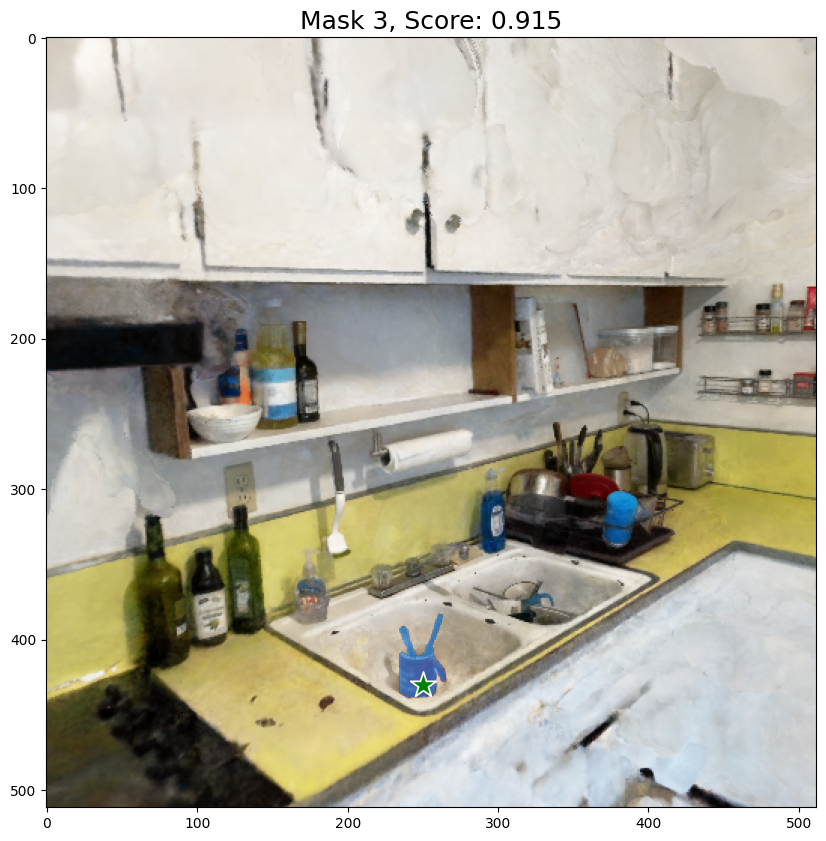

In [81]:


predictor.set_image(image)

# input_point = np.array([[270,180],
#                         [200,280]])
# input_point = np.array([[170,420],
#                         [300,420],
#                         [200,280]])
# input_point = np.array([[250,240],
#                         [250,310],])
input_point = np.array([
                        # [180,300],
                        # [250,300],
                        # [120,360]
                        
                      
                        # [130,100],
                        # [110,10]
                        
                        # [150,450]
                        [250,430],
                        
             
                        # [330,350]
                        # [200,200]
                        # [500,400],
                        # [380,280]
                        
                        ])
input_label = np.ones([input_point.shape[0]])
# input_label[0] = 1

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    # mask_input=new_input[None,...],
    multimask_output=True,
)


mask = masks[2] * 255

# mask = ((masks[0] + input_mask) > 1 ) * 255 
cv2.imwrite(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), mask)

# mask = np.ones_like(mask[0])
# cv2.imwrite(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), mask)
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    # show_box(input_box, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('on')
    plt.show() 
    


frame_00022


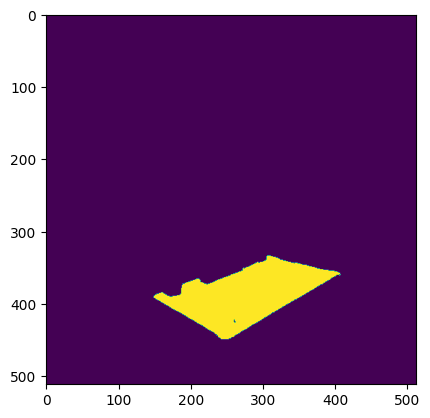

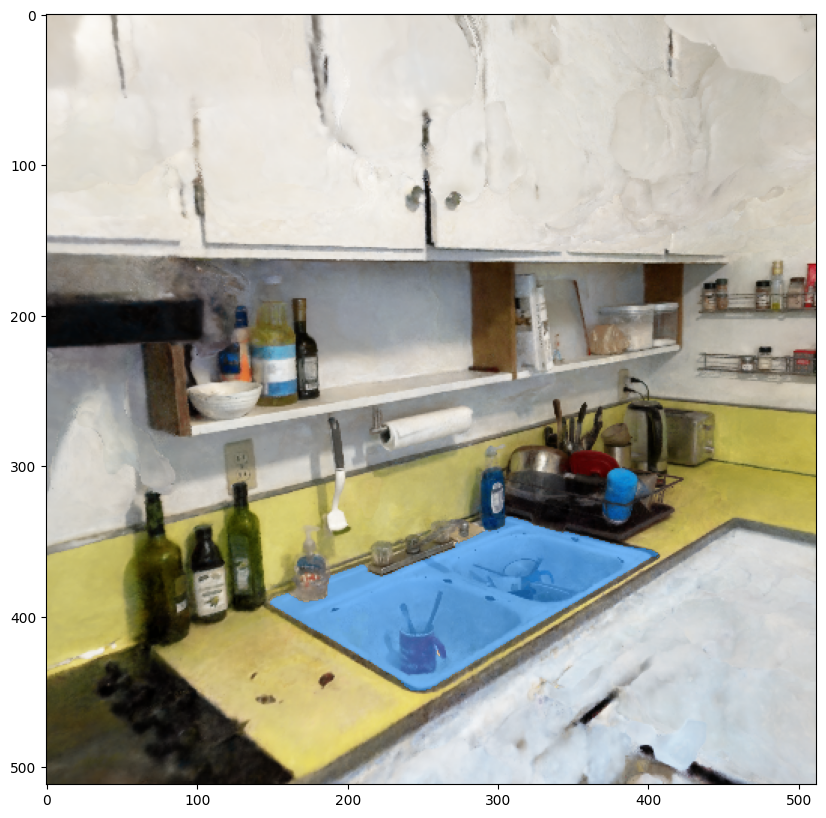

True

In [83]:
# img_index = 0

image = cv2.imread(path.join(target_root, 'ori_'+image_names[img_index]+'.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(image_names[img_index])
mask = cv2.imread(path.join(target_root, 'mask_'+image_names[img_index]+'.png'), cv2.IMREAD_GRAYSCALE)
# mask = cv2.imread(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), cv2.IMREAD_GRAYSCALE)


# mask = mask * 255

output = refiner.refine(image, mask, fast=False, L=900) 
output = (output > 128) * 255
plt.imshow(output)
plt.show()
plt.close()


plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(output / 255, plt.gca())
plt.show() 
plt.close() 

np.save(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.npy'), output)
cv2.imwrite(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), output)


This code is used to denoise

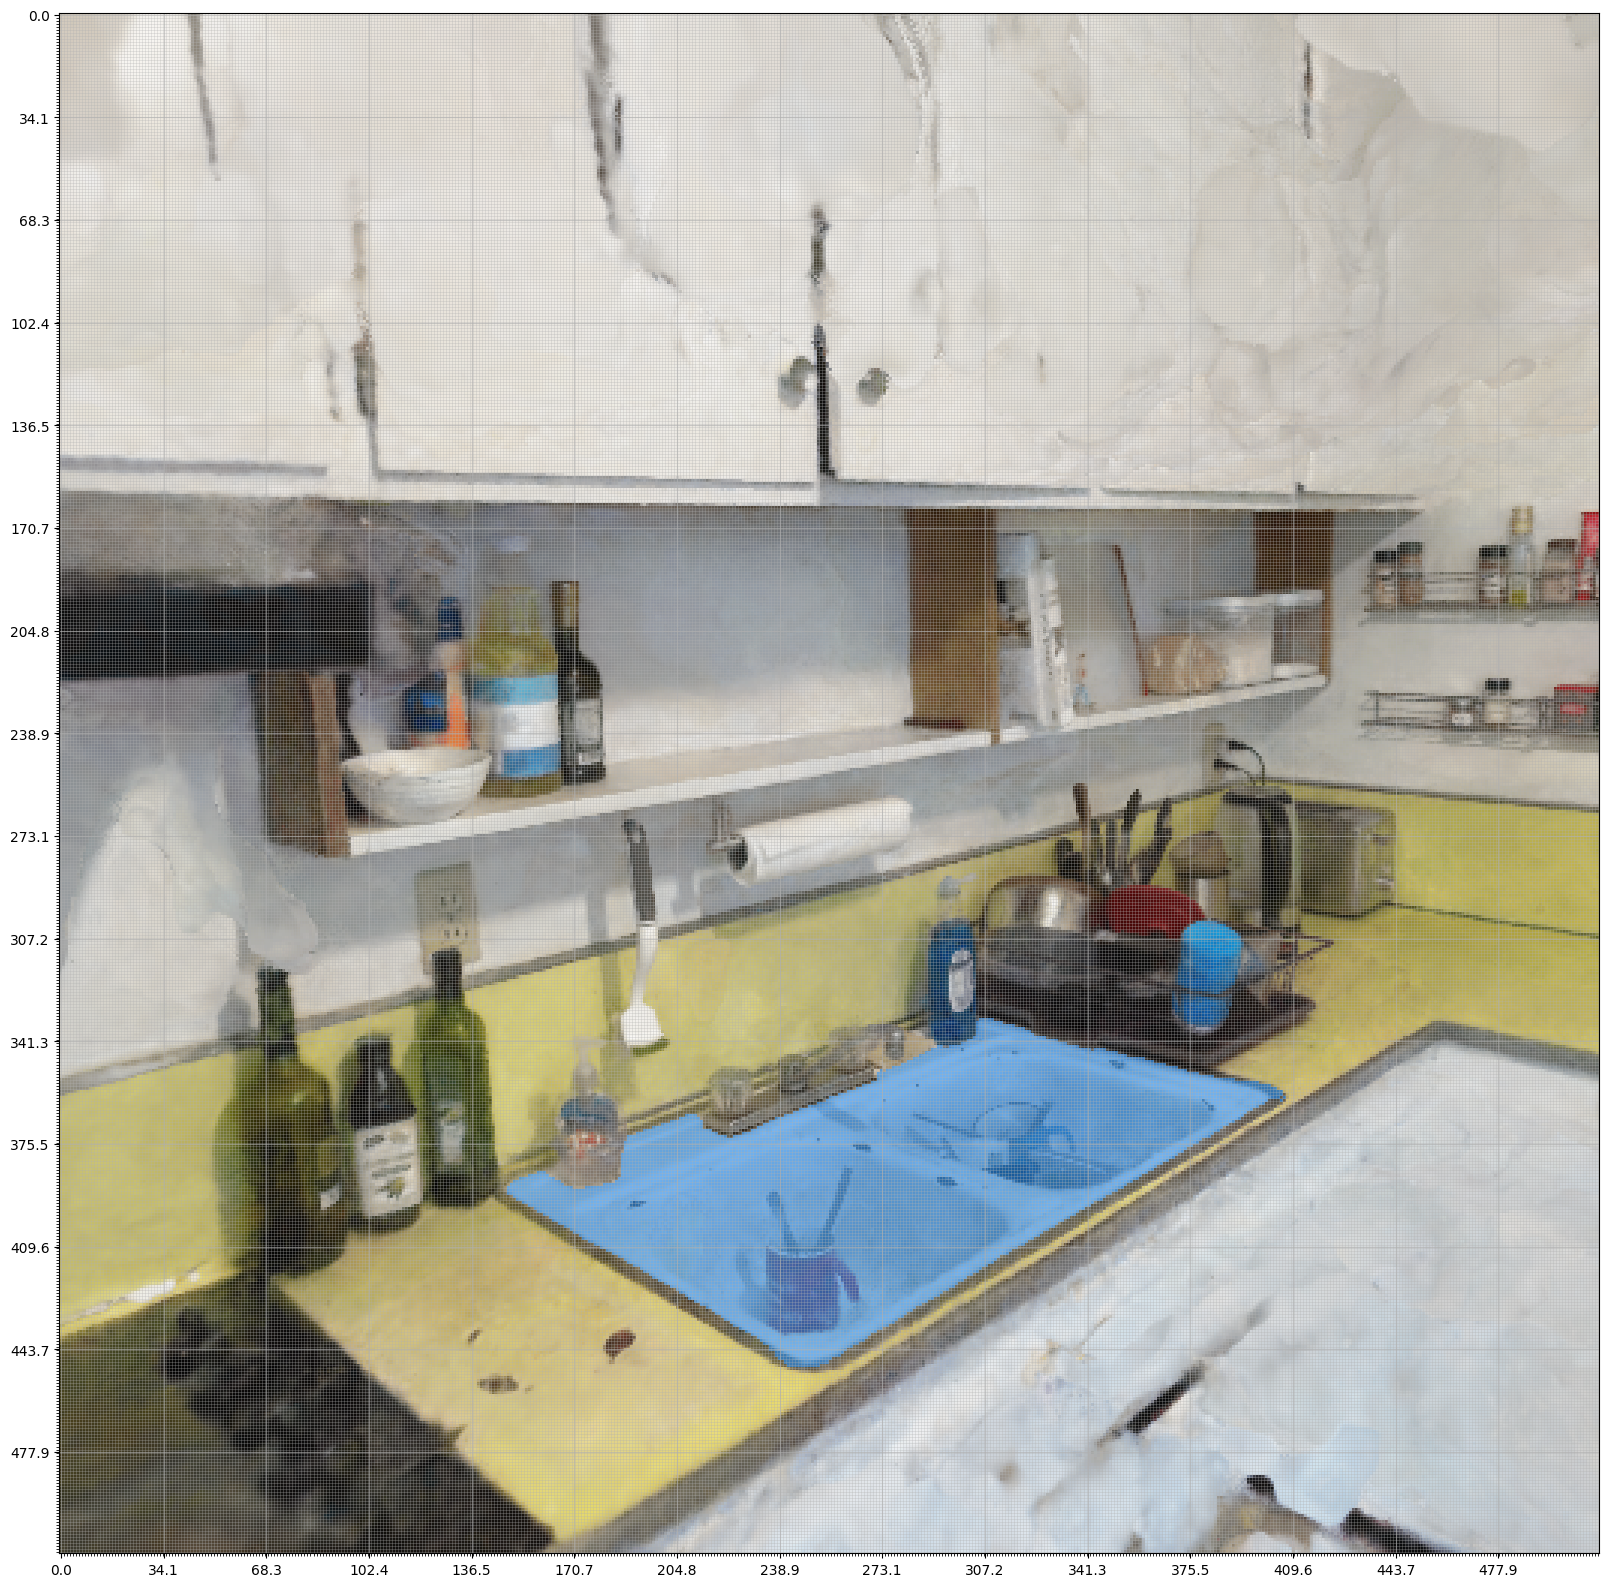

In [85]:
# img_name = path.join(target_root, 'mask_'+image_names[img_index]+'.png')
img_name = path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png')
# img_name = path.join(target_root, 'refined_mask_'+'DSC07973'+'.png')

a = cv2.imread(img_name)



a[400:430,250:270] = 255
# a[450:512,0:100] = 255
# a[400:455,204:234] = 255


# a = b

# a[190:240,390:443] = 255
# a[200:240,443:490] = 255

# a[255:260,220:230] = 255

# a[120:180, 220:360] = 0
# a[180:235, 250:290] = 0
# a[170:180, 240:280] = 0
# a[185:230, 245:250] = 0
# a[190:225, 240:245] = 0
# a[185:230, 290:295] = 0
# a[190:225, 295:300] = 0

# a[400:440, 240:260] = 0
# a[385:440, 230:244] = 0

# a[194:200, 258:268] = 0
# a[236:243, 293:300] = 0
# a[230:236:, 287:298] = 0

# a[230:236:, 287:298] = np.array([255,0,0])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20,20))

major_ticks_top = np.linspace(0, 512, 16)
minor_ticks_top = np.linspace(0, 512, 513)


axes.set_xticks(major_ticks_top)
axes.set_yticks(major_ticks_top)
axes.set_xticks(minor_ticks_top, minor=True)
axes.set_yticks(minor_ticks_top, minor=True)
axes.grid(which="major", alpha=0.6)
axes.grid(which="minor", alpha=0.3)

plt.imshow(image)
show_mask(a[..., 0] / 255, plt.gca())
plt.show()
plt.close()
cv2.imwrite(img_name, a)
np.save(img_name.replace('.png', '.npy'), a[..., 0] / 255)

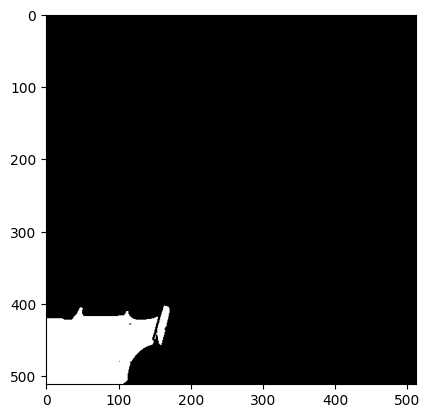

True

In [53]:
img_name = path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png')
a = cv2.imread(img_name)
img_name = path.join(target_root, 'mask_'+image_names[img_index]+'_1.png')

b = cv2.imread(img_name)
temp = a>0 
temp0 =(b > 128)
temp = (temp + temp0) > 0

temp = temp * 255
plt.imshow(temp)
plt.show()
plt.close()
cv2.imwrite(path.join(target_root, 'refined_mask_'+image_names[img_index]+'.png'), temp)

This is used to write the json into data split

In [4]:
import json
import random
import os

with open('scenes_metadata_v2.json') as f:
    meta = json.load(f)
    
data_root = '/ssddata/yliugu/data'

for k in list(meta.keys()):
    k = 'waldo_kitchen'
    eval_pose_path = os.path.join(data_root, k, 'eval_pose.json')
    if os.path.isfile(eval_pose_path):
        continue
        with open(eval_pose_path) as f:
            eval_pose = json.load(f)
        for o in list(meta[k].keys()):
            eval_dict = {}
            eval_dict['test'] = eval_pose[o]['auto']
            eval_dict['test'].extend(eval_pose[o]['select'])
            with open(os.path.join(data_root, k, f'train_{o}_nerf', 'data_split.json'), '+w') as f:
                json.dump(eval_dict,f, indent=4)
    else:
        
        for o in list(meta[k].keys()):
            o = 'sink'
            image_root = os.path.join(data_root, k, f'train_{o}_nerf')
            image_names = [img for img in os.listdir(image_root) if img[-3:] == 'png']
            
            n_img = 10
            if len(image_names) < 80:
                n_img = len(image_names) // 8
            eval_dict = {}
            eval_dict['test'] = []
            for _ in range(n_img):
                s = None
                while s  in eval_dict['test'] or s is None:
                    s = random.choice(image_names)[:-10]
                eval_dict['test'].append(s)
            with open(os.path.join(data_root, k, f'train_{o}_nerf', 'data_split.json'), '+w') as f:
                json.dump(eval_dict,f, indent=4)
            break
    break